# Predicting Housing Prices in King County, Washington

#### Griffin Hundley, Malcolm Katzenbach, and Lauren Phipps

***

### Overview  <a id="Overview"></a>

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

[1. Business Problem](#Business-Problem)

[2. Data Understanding](#Data-Understanding)

[3. Data Cleaning](#Data-Cleaning)

[4. Data Modeling](#Data-Modeling)

[5. Evaluation](#Evaluation)

[6. Conclusion](#Conclusion)

***

## Business Problem  <a id="Business-Problem"></a>

When listing a house for sale, it is important to price it accurately. Houses that are priced too high can sit on the market for months, which can lead to the price eventually being dropped to generate sales. According to a study from Zillow, in the Seattle area, a house that is on the market for 2 months will lead to a 5% drop in price. On the other side, if a house is priced too low, a seller is not maximizing the return on their house. In both of these cases, the seller is not getting as much money as they can and the realtor is not maximizing their comission for the sale, as commission is tied to selling price. 

To combat this, we are creating a model to estimate the price of a home based on certain characterisitics of the house. This will allow realtors to more accurately price the house to ensure it sells quickly and at a fair price. 

The questions we are targeting are:

   1) Which house features most impact the price of house?

   2) How do these feature impact the price of a house?

***
Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

What are the business's pain points related to this project?
How did you pick the data analysis question(s) that you did?
Why are these questions important from a business perspective?

***

## Data Understanding  <a id="Data-Understanding"></a>

The data being used is publicly available housing data from King County, Washington from 2014-2015. The dataset contains ~21,600 rows, with each row representing the sale of a house in King County. The columns represent features of that house. The target variable is the price of the house, which will be used to determine the effect of several features on houses.  Prior to any data analysis, the test data is split from the training data to prevent data leakage. The split is 80% training, 20% testing.  

***

Questions to consider:

Where did the data come from, and how do they relate to the data analysis questions?
What do the data represent? Who is in the sample and what variables are included?
What is the target variable?
What are the properties of the variables you intend to use?

Import packages, run code, explore data
***

In [1]:
import datacleaning as dc
import linregvis as lrv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split 
from sklearn.dummy import DummyRegressor
from statsmodels.graphics.regressionplots import abline_plot
from sklearn.metrics import mean_squared_error
%matplotlib inline
sns.set_style('darkgrid')
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick

In [2]:
# Getting the initial data and splitting into test and training sets in an 80:20 split
df = dc.test_split(
    dc.get_data('data/kc_house_data.csv')
)
X_train = df[0]
X_test = df[1]
y_train = df[2]
y_test = df[3]

In [3]:
X_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5052,6744700285,3/11/2015,4,3.50,3270,15160,1.00,0.00,2.00,3,8,1660,1610.0,1997,nan,98155,47.74,-122.29,2790,15160
8658,3630010040,5/23/2014,3,2.00,1540,1827,2.00,0.00,0.00,3,8,1540,0.0,2005,0.00,98029,47.55,-122.00,1540,1827
16841,2881700231,4/22/2015,3,1.75,1440,11364,1.00,0.00,0.00,3,7,1440,0.0,1985,0.00,98155,47.74,-122.33,1950,9390
9439,2312400230,9/24/2014,3,2.25,1810,12000,2.00,0.00,0.00,3,7,1810,0.0,1992,0.00,98003,47.35,-122.30,1720,9916
21301,1732800199,5/11/2015,2,2.50,1680,977,3.00,0.00,0.00,3,9,1680,0.0,2009,0.00,98119,47.63,-122.36,1680,977


In [4]:
X_train.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"17,277.00","17,277.00","17,277.00","17,277.00","17,277.00","17,277.00","15,346.00","17,226.00","17,277.00","17,277.00","17,277.00","17,277.00","14,197.00","17,277.00","17,277.00","17,277.00","17,277.00","17,277.00"
mean,"4,576,436,161.86",3.37,2.12,"2,085.54","15,233.44",1.49,0.01,0.24,3.41,7.66,"1,793.74","1,970.91",84.91,"98,078.00",47.56,-122.21,"1,988.33","12,957.74"
std,"2,879,359,277.94",0.90,0.77,924.04,"41,780.09",0.54,0.08,0.77,0.65,1.18,834.27,29.45,402.83,53.45,0.14,0.14,690.02,"28,393.80"
min,"1,000,102.00",1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,115,510,330.00",3.00,1.75,"1,430.00","5,050.00",1.00,0.00,0.00,3.00,7.00,"1,200.00","1,951.00",0.00,"98,033.00",47.47,-122.33,"1,480.00","5,100.00"
50%,"3,904,902,630.00",3.00,2.25,"1,920.00","7,610.00",1.50,0.00,0.00,3.00,7.00,"1,564.00","1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,445.00",4.00,2.50,"2,560.00","10,688.00",2.00,0.00,0.00,4.00,8.00,"2,220.00","1,997.00",0.00,"98,118.00",47.68,-122.12,"2,370.00","10,080.00"
max,"9,900,000,190.00",11.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,13.00,"9,410.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"


## Data Preparation  <a id="Data-Preparation"></a>

The first step was to split the data into the training set and the test set. This was done as an 80%/20% split, respectively.

From here we dropped the following columns: view, lat, long, zipcode, and sqft_basement. We changed the date to a datetime datatype and filled in the null values for waterfront as zeroes since most homes are not waterfront and it would likely be something that was specified if so. We also created two new features. First is ratio15, which is the ratio of the size of the house compared to the homes around it, using the sqft_living and sqft_living15. The other is years old, with the year built subtracted from 2020. Lastly, we created dummy variables for the conditions. 

***
Questions to consider:

Were there variables you dropped or created?
How did you address missing values or outliers?
Why are these choices appropriate given the data and the business problem?


In [5]:
# Data cleaning, dropping unused columns, feature engineering, dummy columns
X_train = dc.clean_it(df[0])
X_test = dc.clean_it(df[1])

## Data Modeling  <a id="Data-Modeling"></a>

The first step in modeling was to look at the relationship between price (the target variable) and each of the features in the data set. This was done by creating a pairplot. These pairplots show that there is a somewhat linear relationship between price and bathrooms, living space (sqft_living), and grade. Describe and justify the process for analyzing or modeling the data.
***
Questions to consider:

How did you analyze or model the data?
How did you iterate on your initial approach to make it better?
Why are these choices appropriate given the data and the business problem?

Run code to model data

***

### Assessment of Linearity Between Price and Features

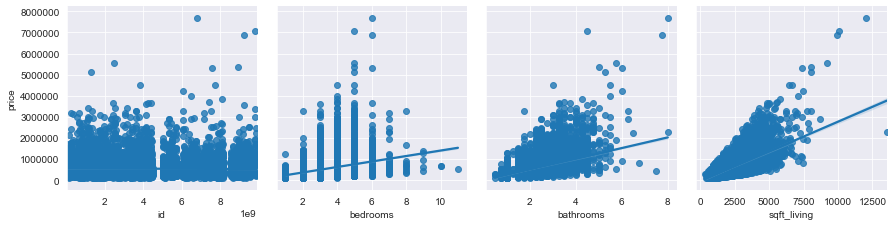

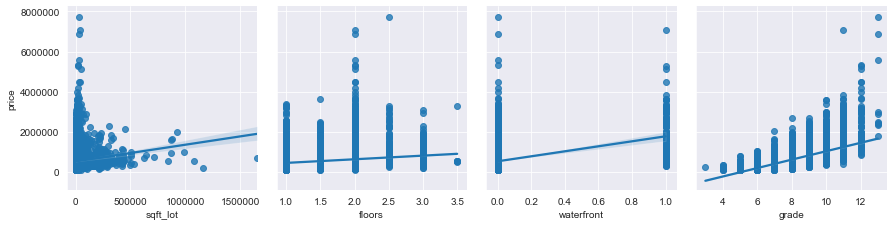

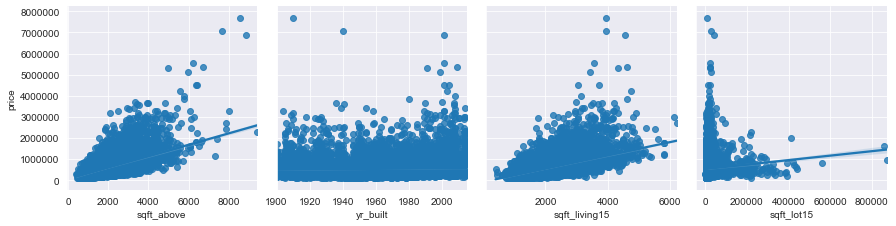

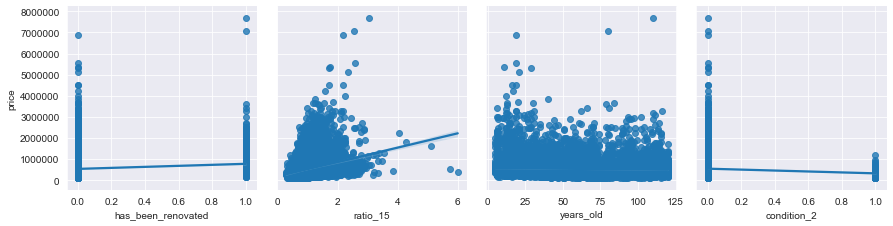

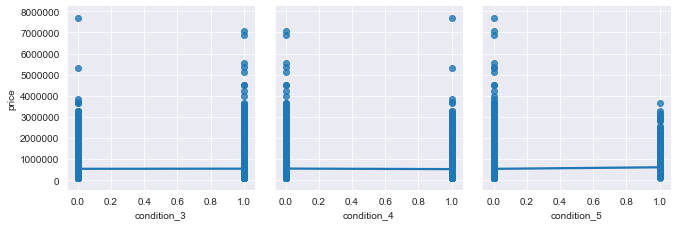

In [6]:
# Break the columns in groups to plot 4 on a row at a time
df = pd.concat([X_train, y_train], axis = 1)
n = 4
features = list(X_train.drop(columns = 'date').columns)
row_groups= [features[i:i+n] for i in range(0, len(features), n) ]
for i in row_groups:
    pp = sns.pairplot(data=df, y_vars=['price'],x_vars=i, kind="reg", height=3)

The relationship between living space and price looks the strongest so that was the feature we started to investigate further. Looking at just that variable we made a regression plot that also shows the distribution of each variable. 

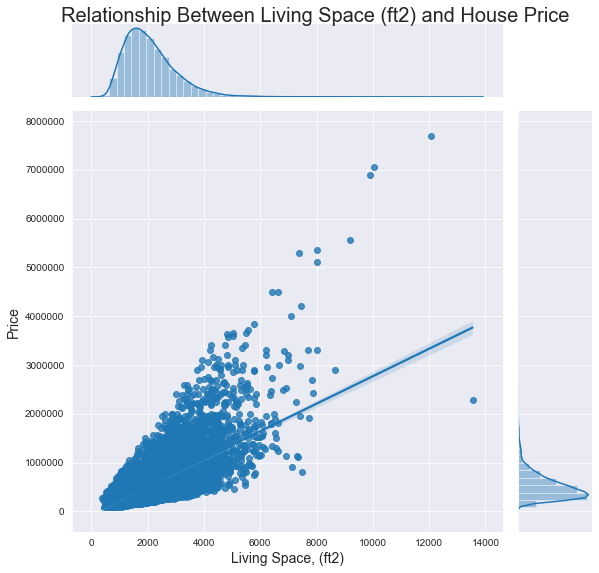

In [7]:
df = pd.concat([X_train, y_train], axis = 1)
fig = sns.jointplot(x="sqft_living", y="price", data=df, kind="reg", height = 8, ratio = 5)
fig.fig.suptitle("Relationship Between Living Space (ft2) and House Price", fontsize = 20)
fig.fig.subplots_adjust(top=0.95)
fig.set_axis_labels(xlabel = 'Living Space, (ft2)', ylabel = 'Price', fontsize = 14)
sns.set(font_scale = 1)

There is a linear relationship between the variables and both distributions have a slight skew. 


***
### Assessment of Correlation Between Features

Finally, we created a heat map to investigate the linearity within the features to address any possible issues of colinearity in our model as we add in additional features. Any features with a correlation value of greater than 0.7 will not be used together in iterations of a model. 


Text(0.5, 1, 'Heat Map of Correlation Between Predictors')

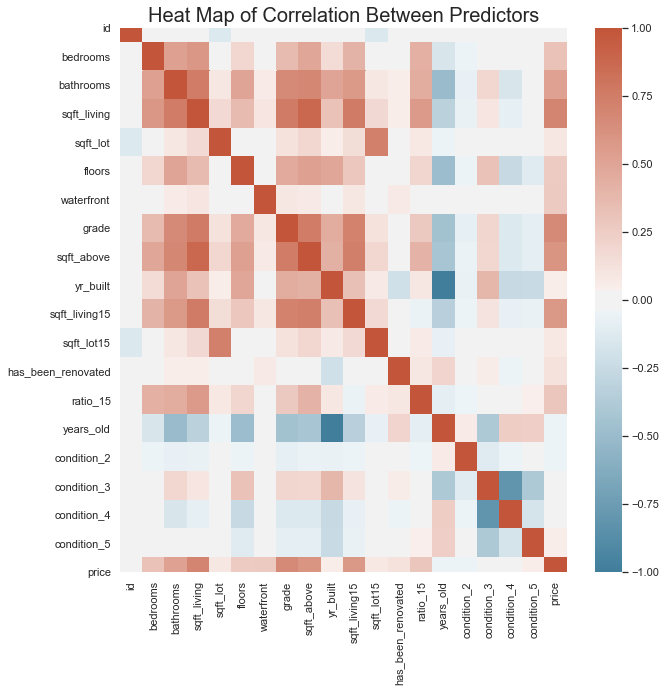

In [8]:
fig,ax = plt.subplots(figsize = (10, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr(), cmap = cmap)
ax.set_title('Heat Map of Correlation Between Predictors', fontsize = 20)

***

### Model Iteration

#### Creation of Dummy Model

First we created a dummy regressor model as a baseline. The dummy regressor uses the default of predicting the mean of the training set and was fitted to the our training X and y. We also checked the baseline score of the model.

In [9]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.0

To find our baseline error, we predicted the y values with our model for the X_train values. My using the mean_squared_error from sklearn metrics, we found by Root Mean Square Error between our predicted and known y_train values.

In [10]:
y_pred = dummy.predict(X_train)
dummy_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
dummy_rmse

372015.8723643869

#### Model 1

The first model we checked was by setting only variable to sq_ft_living. This variable was chosen due to how most people commonly think of the square footage of the house. By using the Ordinary Least Squares function we fitted, we created our model.

In [11]:
formula = "price ~ sqft_living"
model_1 = lrv.run_lr(formula, X_train, y_train)
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                 1.655e+04
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:15:49   Log-Likelihood:            -2.4032e+05
No. Observations:               17277   AIC:                         4.806e+05
Df Residuals:                   17275   BIC:                         4.807e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -4.57e+04   4993.714     -9.152      0.000   -5.55e+04   -3.59e+04
sqft_living   281.6056      2.189    128.634      0.000     277.315     285.897
==============================================================================
Omnibus:                    12287.594   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           502138.509
Skew:                           2.943   Prob(JB):                         0.00
Kurtosis:                      28.747   Cond. No.                     5.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***

From the summary of our model we first check the R-squared value, which tells us the percentage of the variance in price can be explained by this model. It can only explain 48.9% of the variance in price. Then by checking the p value for the coefficient of the sqft_living variable to check if it is signficant to our model or not. Using a confidence level of 0.05, because the p value is less than 0025, we can reject the null hypothesis that the coefficient is not significantly different from zero. The coefficient for sqft_living tells us that for every square foot in the house, the price of the house increase by $281.61. 

Next we create the y prediction by using the X_train values using this first model. The Root Mean Squared Error is then calculated.

In [12]:
y_pred = model_1.predict(X_train)
model_1_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_1_rmse

265871.8790296068

The Root Mean Squared Error (RMSE) is equal to 265871.88, which is less than the RMSE for the baseline model. This indicates that this model is better than our baseline model.

With the first model being only a basic linear regression model, we graph a scatter plot of the price vs. sqft_living and draw the regression line.

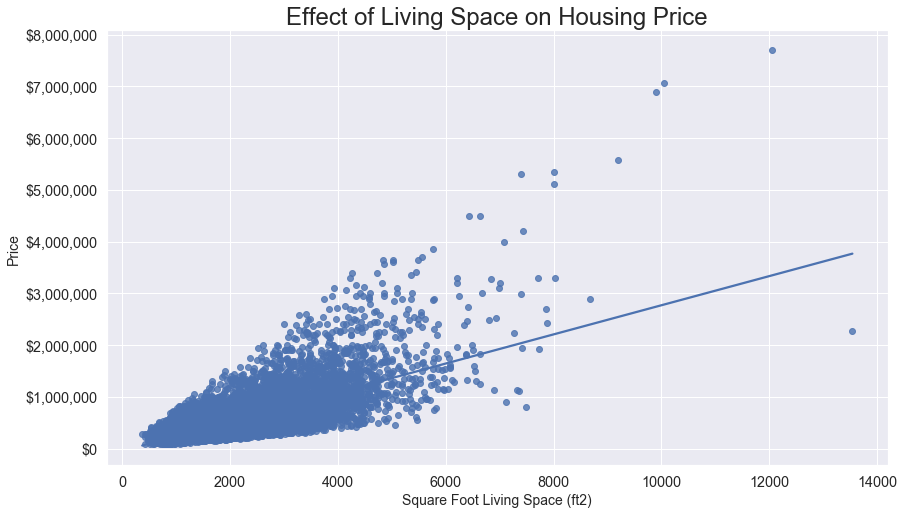

In [13]:
fig, ax = plt.subplots(figsize = (14,8))
ax = sns.regplot(X_train.sqft_living, y_train, ci = None)
ax.set_xlabel('Square Foot Living Space (ft2)', fontsize = 14)
ax.set_ylabel('Price', fontsize = 14)
ax.set_title('Effect of Living Space on Housing Price', fontsize = 24)
ax.tick_params(labelsize = 14)
lrv.dollar_ticks(ax)

#### Model 2

The second model expands on the previous model by checking the condition of the house. Using the condition variable we created dummy variables for each level of condition of which there are 5. Using the ols function and fitting the data, we created the second model with price the dependent variable and sqft_living and our condition dummy variables as the independent variables.

In [14]:
formula = "price ~ sqft_living + condition_2 + condition_3 + condition_4 + condition_5"
model_2 = lrv.run_lr(formula, X_train, y_train)
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     3396.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:15:49   Log-Likelihood:            -2.4021e+05
No. Observations:               17277   AIC:                         4.804e+05
Df Residuals:                   17271   BIC:                         4.805e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept        2e+04   5.77e+04      0.347      0.729   -9.31e+04    1.33e+05
sqft_living   283.7182      2.192    129.451      0.000     279.422     288.014
condition_2 -9.774e+04   6.19e+04     -1.578      0.114   -2.19e+05    2.36e+04
condition_3  -8.75e+04   5.78e+04     -1.515      0.130   -2.01e+05    2.57e+04
condition_4 -5.305e+04   5.78e+04     -0.918      0.359   -1.66e+05    6.03e+04
condition_5  1.868e+04   5.81e+04      0.321      0.748   -9.53e+04    1.33e+05
==============================================================================
Omnibus:                    12317.028   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           513085.522
Skew:                           2.947   Prob(JB):                         0.00
Kurtosis:                      29.038   Cond. No.                     1.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In model 2, the R-squared value is 0.496. This is only .008 better than the previous model. When the p values are examined, the sqft_living is still equal to 0.000, however the conditions all have a p value greater than 0.1. Keeping are confidence levels the same, we cannot reject the null hypothesis that the coefficient is significantly different from zero. So we can conclude that condition feature is not significantly important to the price value.

In [15]:
y_pred = model_2.predict(X_train)
model_2_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_2_rmse

264173.2388625841

Checking the RMSE of model two confirms what are R-squared value implied. The RMSE decreased 1000 from the previous model, which is not significant.

#### Model 3

In the third model, the condition dummy variables are removed from the formula due to not being significant and expanded by adding grade, waterfront, years_old, and ratio_15. 

In [16]:
formula = "price ~ sqft_living + grade + waterfront + years_old + ratio_15"
model_3 = lrv.run_lr(formula, X_train, y_train)
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     6029.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:15:49   Log-Likelihood:            -2.3740e+05
No. Observations:               17277   AIC:                         4.748e+05
Df Residuals:                   17271   BIC:                         4.749e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.764e+05   1.79e+04    -54.461      0.000   -1.01e+06   -9.41e+05
sqft_living   199.9340      3.476     57.525      0.000     193.121     206.747
grade        1.334e+05   2467.811     54.063      0.000    1.29e+05    1.38e+05
waterfront   8.105e+05   2.16e+04     37.590      0.000    7.68e+05    8.53e+05
years_old    3591.0536     65.162     55.109      0.000    3463.329    3718.778
ratio_15    -9.693e+04   6687.463    -14.495      0.000    -1.1e+05   -8.38e+04
==============================================================================
Omnibus:                    13352.225   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1010499.346
Skew:                           3.129   Prob(JB):                         0.00
Kurtosis:                      39.940   Cond. No.                     2.89e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In model 3, the R-squared value is 0.636. This is an increase of 0.14 or 14% than the previous model. The p values for all the features are 0.000, thus for all coefficients the null hypothesis that the coefficient is not significantly different from zero is rejected. All the new features are significant in the prediction of price and increases the percentage of variance in price that the model is able to explain.

In [17]:
y_pred = model_3.predict(X_train)
model_3_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_3_rmse

224526.43788567488

The RMSE from model 3 is 224526, which is a decrease of nearly 40000. In addition to the R-squared value, this model is much better at predicting the price of homes.

#### Model 4

In the fourth model, the sqft_living is removed due the high mult-linear correlation between the variable and grade and ratio_15. Bathrooms has a high multi-linear correlation with sqft_living, but not as high as with grade or ratio_15. We use bathrooms as a possible replacement for sqft_living.

In [18]:
formula = "price ~ bathrooms + grade + waterfront + years_old + ratio_15"
model_4 = lrv.run_lr(formula, X_train, y_train)
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     5060.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:15:50   Log-Likelihood:            -2.3833e+05
No. Observations:               17277   AIC:                         4.767e+05
Df Residuals:                   17271   BIC:                         4.767e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.512e+06   1.54e+04    -97.937      0.000   -1.54e+06   -1.48e+06
bathrooms   1.252e+05   3603.198     34.747      0.000    1.18e+05    1.32e+05
grade       1.992e+05   2087.093     95.456      0.000    1.95e+05    2.03e+05
waterfront  8.617e+05   2.27e+04     37.924      0.000    8.17e+05    9.06e+05
years_old   4550.2752     73.395     61.997      0.000    4406.414    4694.136
ratio_15    3.194e+04   6355.527      5.026      0.000    1.95e+04    4.44e+04
==============================================================================
Omnibus:                    15119.423   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1649749.027
Skew:                           3.714   Prob(JB):                         0.00
Kurtosis:                      50.292   Cond. No.                         729.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The fourth model has an R-squared value of 0.594. This is less than the 0.636 of the previous model. Though it decreases possible error due to multi-linear correlation. The p values for the features used are all 0.000, thus rejecting the null hypothesis that the coefficient is not significantly different from zero. Taking into account the multi-linear correlation, this model is the best improvement from the base model.

In [19]:
y_pred = model_4.predict(X_train)
model_4_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_4_rmse

236951.60963766123

The RMSE is equal 236951 which is an increase from model three, but still a 30000 decrease from model 2. 

#### Model 5

For the fifth model, the feature has_been_renovated was added to see if renovating a house has a predictable impact on the price.

In [20]:
formula = "price ~ bathrooms + grade + waterfront + years_old + ratio_15 + has_been_renovated"
model_5 = lrv.run_lr(formula, X_train, y_train)
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     4217.
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        11:15:50   Log-Likelihood:            -2.3833e+05
No. Observations:               17277   AIC:                         4.767e+05
Df Residuals:                   17270   BIC:                         4.767e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.509e+06   1.56e+04    -96.957      0.000   -1.54e+06   -1.48e+06
bathrooms           1.246e+05   3625.254     34.373      0.000    1.18e+05    1.32e+05
grade               1.992e+05   2087.502     95.406      0.000    1.95e+05    2.03e+05
waterfront          8.598e+05   2.28e+04     37.779      0.000    8.15e+05    9.04e+05
years_old           4521.8886     75.888     59.586      0.000    4373.139    4670.638
ratio_15            3.167e+04   6357.925      4.982      0.000    1.92e+04    4.41e+04
has_been_renovated  1.503e+04   1.02e+04      1.471      0.141   -5003.048    3.51e+04
==============================================================================
Omnibus:                    15107.946   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1644417.619
Skew:                           3.710   Prob(JB):                         0.00
Kurtosis:                      50.215   Cond. No.                         730.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The fifth model gives an identical $R^2$ value, and the p-value is greater than the significance level $\alpha=0.05$ so this is not a statistically significant relationship

In [21]:
y_pred = model_5.predict(X_train)
model_5_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_5_rmse

236936.77599405398

The RMSE is barely a decrease at all from the previous model.

***

### Validation of Model

#### Analysis of Residuals

In [22]:
mmean = model_four.resid.mean()
mmin = model_four.resid.min()
mmax = model_four.resid.max()
normalized_residuals = (model_four.resid - mmean)/(mmax - mmin)

NameError: name 'model_four' is not defined

In [ ]:
t = model_four.fittedvalues
tmean = model_four.resid.mean()
tmin = model_four.resid.min()
tmax = model_four.resid.max()
normalized_predicted = (t - tmean)/(tmax - tmin)

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))
ax.set_xlabel('Normalized Residuals', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Frequency of Normalized Residuals', fontsize = 24)
ax.set(xlim=(-0.25,.25))
sns.distplot(normalized_residuals, bins = 100);

#### Homoskedasticity Test

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))
ax.set_xlabel('Normalized Predicted Price', fontsize = 14)
ax.set_ylabel('Normalized Residuals', fontsize = 14)
ax.set_title('Residuals vs Predicted Values for Homoskedasticity', fontsize = 24)
sns.scatterplot(x = normalized_predicted, y = normalized_residuals);

#### QQ Plot

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
stats.probplot(normalized_residuals, plot=plt)
ax.set_title('QQ Plot Probability of residuals', fontsize = 24)
ax.set_xlabel('Residuals', fontsize = 14)
ax.set_ylabel('Probability', fontsize = 14)
ax.legend(['Residuals','Normal line']);

## Evaluation  <a id="Evaluation"></a>

Evaluate how well your work solves the stated business problem.

Questions to consider:

How do you interpret the results?
How well does your model fit your data? How much better is this than your baseline model?
How confident are you that your results would generalize beyond the data you have?
How confident are you that this model would benefit the business if put into use?

***

## Conclusion  <a id="Conclusion"></a>

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

What would you recommend the business do as a result of this work?
What are some reasons why your analysis might not fully solve the business problem?
What else could you do in the future to improve this project?

***
